# FNO on Darcy flow 

Use Fourier Neural Operator (FNO) to solve Darcy flow problem.
We learn a mapping (operator) between a permeability field to the solution pressure field:

$$
-\nabla \cdot \left( k(x) \nabla u(x) \right) = f(x), x\in D,
$$

where $D$ is the domain, $k(x)$ is the permeability field, $u(x)$ is the pressure field, and $f(x)$ is the source term, the operator we want to learn: $\mathcal{L}: k(x) \to u(x)$.

Domain $D$ is a 2D square domain $[0, 1]^2$, and both fields ($k(x), u(x)$) are discretized into 2D matrix $\mathbf{K}, \mathbf{u} \in \mathbb{R}^{N\times N}$

In [3]:
# packages
import torch
import matplotlib.pyplot as plt
import sys
from neuralop.models import FNO
from neuralop import Trainer
from neuralop.training import AdamW
from neuralop.data.datasets import load_darcy_flow_small
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss

device = 'cpu'

In [4]:
# load dataset
train_loader, test_loaders, data_processor = load_darcy_flow_small(
        n_train=1000, batch_size=32,
        test_resolutions=[16, 32], n_tests=[100, 50],
        test_batch_sizes=[32, 32],
)
data_processor = data_processor.to(device)

Loading test db for resolution 16 with 100 samples 
Loading test db for resolution 32 with 50 samples 


x.shape: torch.Size([1, 16, 16])
y.shape: torch.Size([1, 16, 16])


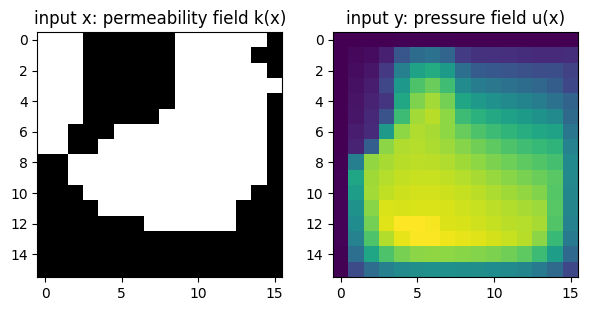

In [12]:
# check dataset
index = 0
data = train_loader.dataset[index]
x = data['x']
y = data['y']
print(f'x.shape: {x.shape}') # binary value (0 or 1), x grid, y grid
print(f'y.shape: {y.shape}') # solution value, x grid, y grid

# plot input x and input y
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(2, 2, 1)
ax.imshow(x[0], cmap='gray')
ax.set_title('input x: permeability field k(x)')
ax = fig.add_subplot(2, 2, 2)
ax.imshow(y.squeeze())
ax.set_title('input y: pressure field u(x)')
plt.show()

In [15]:
# model setup
model = FNO(n_modes=(16, 16),
             in_channels=1,
             out_channels=1,
             hidden_channels=32,
             projection_channel_ratio=2)
model = model.to(device)

n_params = count_model_params(model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()


Our model has 1192801 parameters.


In [16]:
# model setup
optimizer = AdamW(model.parameters(),
                                lr=8e-3,
                                weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

# loss functions
l2loss = LpLoss(d=2, p=2)
h1loss = H1Loss(d=2)

train_loss = h1loss
eval_losses={'h1': h1loss, 'l2': l2loss}


print('\n### MODEL ###\n', model)
print('\n### OPTIMIZER ###\n', optimizer)
print('\n### SCHEDULER ###\n', scheduler)
print('\n### LOSSES ###')
print(f'\n * Train: {train_loss}')
print(f'\n * Test: {eval_losses}')
sys.stdout.flush()


### MODEL ###
 FNO(
  (positional_embedding): GridEmbeddingND()
  (fno_blocks): FNOBlocks(
    (convs): ModuleList(
      (0-3): 4 x SpectralConv(
        (weight): DenseTensor(shape=torch.Size([32, 32, 16, 9]), rank=None)
      )
    )
    (fno_skips): ModuleList(
      (0-3): 4 x Flattened1dConv(
        (conv): Conv1d(32, 32, kernel_size=(1,), stride=(1,), bias=False)
      )
    )
    (channel_mlp): ModuleList(
      (0-3): 4 x ChannelMLP(
        (fcs): ModuleList(
          (0): Conv1d(32, 16, kernel_size=(1,), stride=(1,))
          (1): Conv1d(16, 32, kernel_size=(1,), stride=(1,))
        )
      )
    )
    (channel_mlp_skips): ModuleList(
      (0-3): 4 x SoftGating()
    )
  )
  (lifting): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
      (1): Conv1d(64, 32, kernel_size=(1,), stride=(1,))
    )
  )
  (projection): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
      (1): Conv1d(64, 

In [17]:
# train
trainer = Trainer(model=model, n_epochs=20,
                  device=device,
                  data_processor=data_processor,
                  wandb_log=False,
                  eval_interval=3,
                  use_distributed=False,
                  verbose=True)

trainer.train(train_loader=train_loader,
              test_loaders=test_loaders,
              optimizer=optimizer,
              scheduler=scheduler,
              regularizer=False,
              training_loss=train_loss,
              eval_losses=eval_losses)

Training on 1000 samples
Testing on [50, 50] samples         on resolutions [16, 32].
Raw outputs of shape torch.Size([32, 1, 16, 16])
[0] time=3.24, avg_loss=0.6611, train_err=20.6603
Eval: 16_h1=0.3920, 16_l2=0.2611, 32_h1=0.5924, 32_l2=0.2818
[3] time=3.27, avg_loss=0.2046, train_err=6.3924
Eval: 16_h1=0.2150, 16_l2=0.1439, 32_h1=0.5070, 32_l2=0.1786
[6] time=3.20, avg_loss=0.1770, train_err=5.5320
Eval: 16_h1=0.1987, 16_l2=0.1286, 32_h1=0.5253, 32_l2=0.1787
[9] time=3.24, avg_loss=0.1592, train_err=4.9759
Eval: 16_h1=0.2616, 16_l2=0.1921, 32_h1=0.5233, 32_l2=0.2109
[12] time=3.42, avg_loss=0.1175, train_err=3.6723
Eval: 16_h1=0.2013, 16_l2=0.1273, 32_h1=0.5219, 32_l2=0.1708
[15] time=3.41, avg_loss=0.1247, train_err=3.8961
Eval: 16_h1=0.2107, 16_l2=0.1239, 32_h1=0.4836, 32_l2=0.1555
[18] time=3.45, avg_loss=0.1021, train_err=3.1903
Eval: 16_h1=0.1928, 16_l2=0.1132, 32_h1=0.5367, 32_l2=0.1687


{'train_err': 2.6738568414002657,
 'avg_loss': 0.0855634189248085,
 'avg_lasso_loss': None,
 'epoch_train_time': 3.3950801999999385}

In [ ]:
# prediction on finer discretization
test_samples = test_loaders[32].dataset

fig = plt.figure(figsize=(7, 7))
for index in range(3):
    data = test_samples[index]
    data = data_processor.preprocess(data, batched=False)
    # Input x
    x = data['x']
    # Ground-truth
    y = data['y']
    # Model prediction
    out = model(x.unsqueeze(0))

    ax = fig.add_subplot(3, 3, index*3 + 1)
    ax.imshow(x[0], cmap='gray')
    if index == 0:
        ax.set_title('Input x')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 2)
    ax.imshow(y.squeeze())
    if index == 0:
        ax.set_title('Ground-truth y')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 3)
    ax.imshow(out.squeeze().detach().numpy())
    if index == 0:
        ax.set_title('Model prediction')
    plt.xticks([], [])
    plt.yticks([], [])

fig.suptitle('Inputs, ground-truth output and prediction (32x32).', y=0.98)
plt.tight_layout()
fig.show()

NameError: name 'test_loaders' is not defined